<a href="https://colab.research.google.com/github/Minh-A/Dacon_ArcticSeaIce_Prediction_2/blob/main/Code_6_KNNR%20stacking%20NewData%20daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모델 여러개 사용

## 함수

In [ ]:
# 그림을 그리는 함수
# 코드공유 - 'DATA loading + Simple EDA + 참고가능 논문' 내의 함수를 약간 변경하였습니다.
# 코드 공유를 해주신 Jay윤님 감사합니다.

def show(npy):
    num_channel = npy.shape[0]
    plt.figure(figsize=(50, 50)) 
    for channel in range(num_channel):
      tmpimg = npy[channel, :, :]
      ax = plt.subplot(1, num_channel, channel+1)  # (행, 열, 데이터 개수) - 그리고 싶은 팜플렛 모양
      ax.title.set_text("Ice")

      ax.imshow(tmpimg)
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
# 소숫점 둘째 자리에서 반올림하는 함수

def fun1(x) : 
  return np.around(x,2)

In [ ]:
# 점수 계산
# 대회안내 - 규칙에 존재하는 산식 코드입니다.

def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    
    return score

def f1_score(true, pred):
    target = np.where((true>250*0.05)&(true<250*0.5))
    
    true = true[target]
    pred = pred[target]
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score
    
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1+1e-8)
    
    return score

In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.neighbors import KNeighborsRegressor  # 사용할 모델입니다.

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
# 2019년 추론 데이터
# 테스팅용
fn1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/public_weekly_test.csv')
dm1 = fn1.iloc[1:,1]
data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/12150.npy')
data = data.reshape(1,448,304,5)

#
for i in tqdm(dm1):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/'+i)
    a = a.reshape(1,448,304,5)
    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

print(data.shape)

#
inference = data

100%|██████████| 23/23 [00:08<00:00,  2.66it/s]

(24, 448, 304)


In [ ]:
# 1차 데이터 불러오기
fn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train.csv')
fn.tail()

week_start  ...                                          data_list
2169  2020-05-18  ...  20200518.npy,20200519.npy,20200520.npy,2020052...
2170  2020-05-25  ...  20200525.npy,20200526.npy,20200527.npy,2020052...
2171  2020-06-01  ...  20200601.npy,20200602.npy,20200603.npy,2020060...
2172  2020-06-08  ...  20200608.npy,20200609.npy,20200610.npy,2020061...
2173  2020-06-15  ...  20200615.npy,20200616.npy,20200617.npy,2020061...

[5 rows x 3 columns]

데이터 전처리

In [ ]:
fn.iloc[1:1+5,1]

1    10001.npy
2    10002.npy
3    10003.npy
4    10004.npy
5    10005.npy
Name: week_file_nm, dtype: object

In [ ]:
def filemake(num,iii):  # num은 시작일보다 1일뒤로 적음
  dm = fn.iloc[num:num+37,1]

  start = fn.iloc[num-1,1]
  data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/{}'.format(start))
  data = data.reshape(1,448,304,5)

  for i in dm:
     a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/'+i)
     a = a.reshape(1,448,304,5)
     data = np.concatenate((data,a), axis=0)

  data = np.array(data)
  data = data[:,:,:,0]


  # train 데이터 셋 생성
  globals()['train{}'.format(iii)] = data[:24]  # 1월부터 6월
  globals()['train{}'.format(iii)] =   globals()['train{}'.format(iii)].reshape(24,448,304)

  # 데이터 셋 형태 변환
  data = data.reshape(38,1,448,304)

  # test 데이터 생성
  globals()['test{}'.format(iii)] = np.array(np.concatenate((data[26], data[27], data[28], data[29], data[30], data[31], data[32], data[33], data[34], data[35], data[36], data[37]), axis=0))  # 7월부터 9월


  # 확인
  print(globals()['train{}'.format(iii)].shape, globals()['test{}'.format(iii)].shape)

In [ ]:
lis = [2099, 2046] # 2019년~2018년


for i,datan in tqdm(enumerate(lis)):
  filemake(datan, i)

1it [00:18, 18.84s/it]

(24, 448, 304) (12, 448, 304)


2it [00:37, 18.52s/it]

(24, 448, 304) (12, 448, 304)


일별 타겟 데이터 불러오기

In [ ]:
# 2차 데이터 불러오기
fn1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/daily_train.csv')
fn1.tail()

date       file_nm
15213  2020-06-17  20200617.npy
15214  2020-06-18  20200618.npy
15215  2020-06-19  20200619.npy
15216  2020-06-20  20200620.npy
15217  2020-06-21  20200621.npy

In [ ]:
fn1.iloc[14867,0], fn1.iloc[14502,0], fn1.iloc[14137,0]

('2019-07-07', '2018-07-07', '2017-07-07')

In [ ]:
def filemake1(num,iii):  # num은 시작일보다 1일뒤로 적음
  dm = fn1.iloc[num:num+83,1]

  start = fn1.iloc[num-1,1]
  data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/daily_train/{}'.format(start))
  data = data.reshape(1,448,304,5)

  for i in dm:
     a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/daily_train/'+i)
     a = a.reshape(1,448,304,5)
     data = np.concatenate((data,a), axis=0)

  data = np.array(data)
  data = data[:,:,:,0]


  # train 데이터 셋 생성
  globals()['test1_{}'.format(iii)] = data
  globals()['test1_{}'.format(iii)] =   globals()['test1_{}'.format(iii)].reshape(84,448,304)

  # 확인
  print(globals()['test1_{}'.format(iii)].shape)

In [ ]:
lis = [14867, 14502, 14137] # 2019년~2018년


for i,datan in tqdm(enumerate(lis)):
  filemake1(datan, i)

1it [01:57, 117.74s/it]

(84, 448, 304)


2it [02:37, 94.20s/it] 

(84, 448, 304)


3it [03:15, 65.07s/it]

(84, 448, 304)


In [ ]:
# test2019 만들기

for i in range(12):
  globals()['test2019{}'.format(i)] = np.array([test1_0[0 +(7*i)] , test1_0[1 +(7*i)] , test1_0[2 +(7*i)] , test1_0[3 +(7*i)] , test1_0[4 +(7*i)] , test1_0[5 +(7*i)] , test1_0[6 +(7*i)]]).mean(axis=0)
  print(globals()['test2019{}'.format(i)].shape)

(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)
(448, 304)


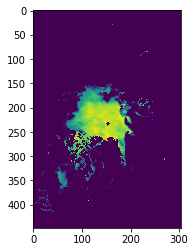

In [ ]:
# 그래프 표시
plt.imshow((test20190).reshape(448,304), interpolation = 'None')
plt.show()

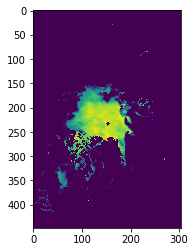

In [ ]:
# 그래프 표시
plt.imshow(np.array([test1_0[0] , test1_0[1] , test1_0[2] , test1_0[3] , test1_0[4] , test1_0[5] , test1_0[6]]).mean(axis=0), interpolation = 'None')
plt.show()

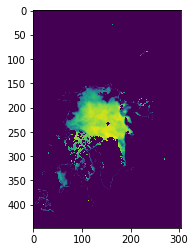

In [ ]:
plt.imshow(test0[0].reshape(448,304), interpolation = 'None')
plt.show()

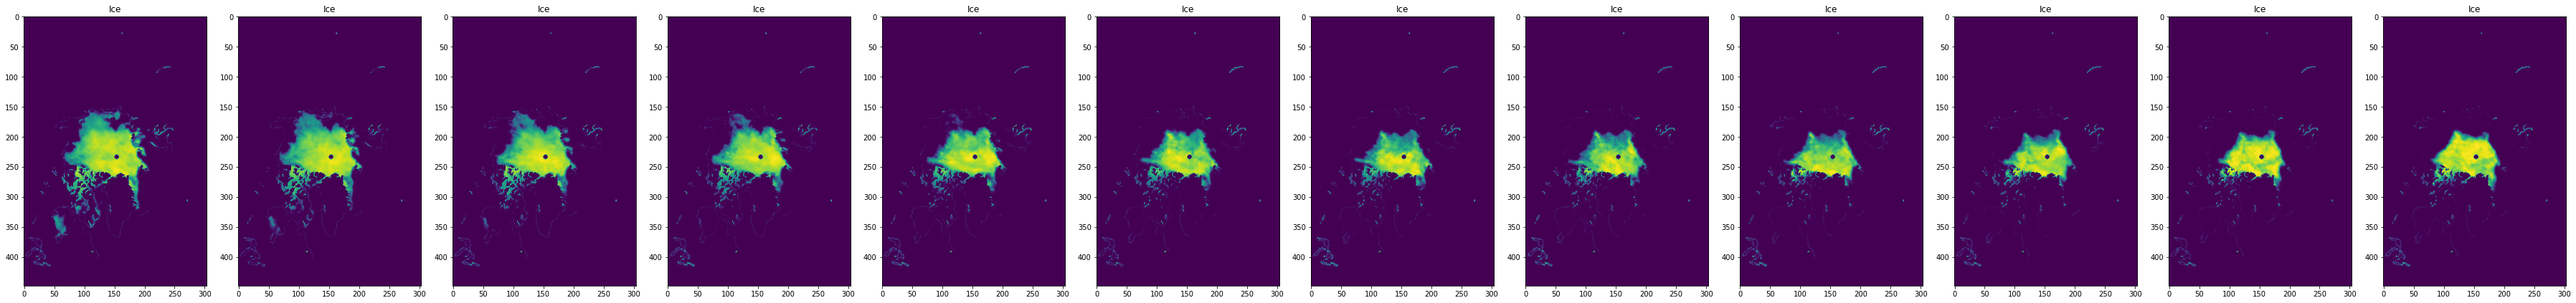

In [ ]:
show(test0)

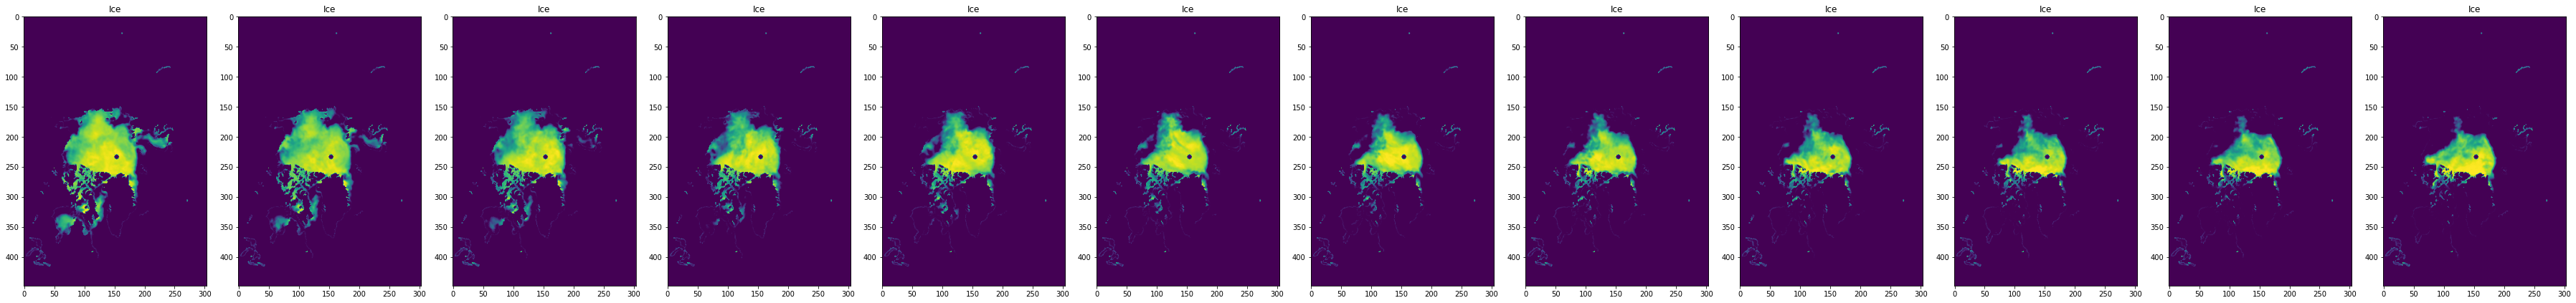

In [ ]:
show(test1)

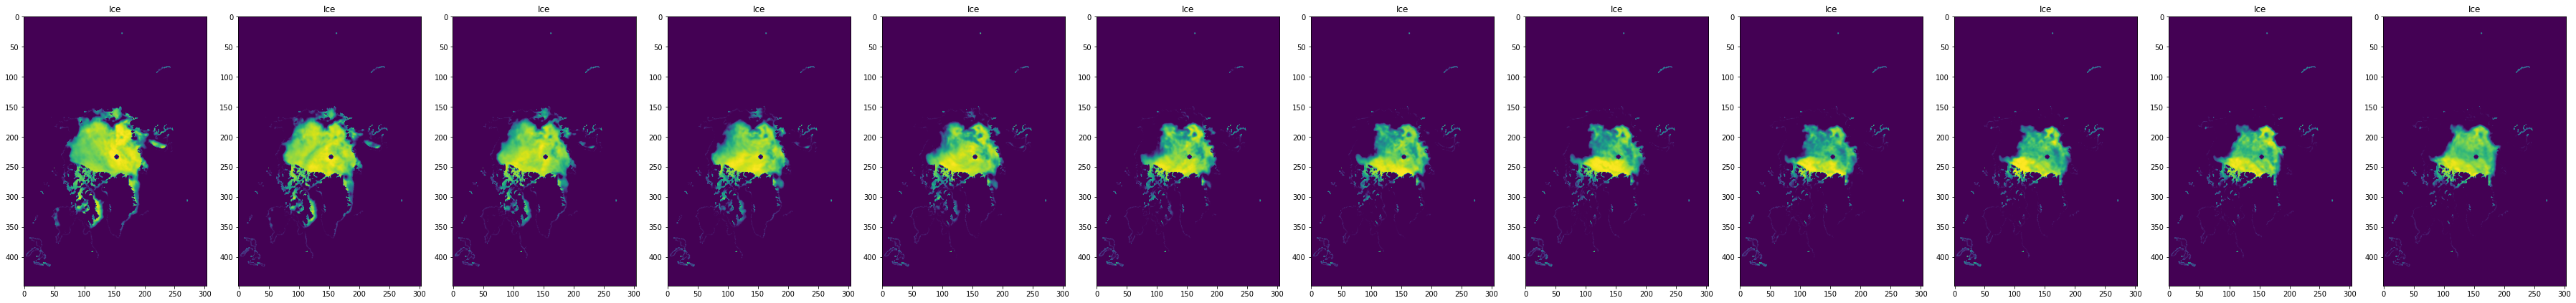

In [ ]:
show(test2)

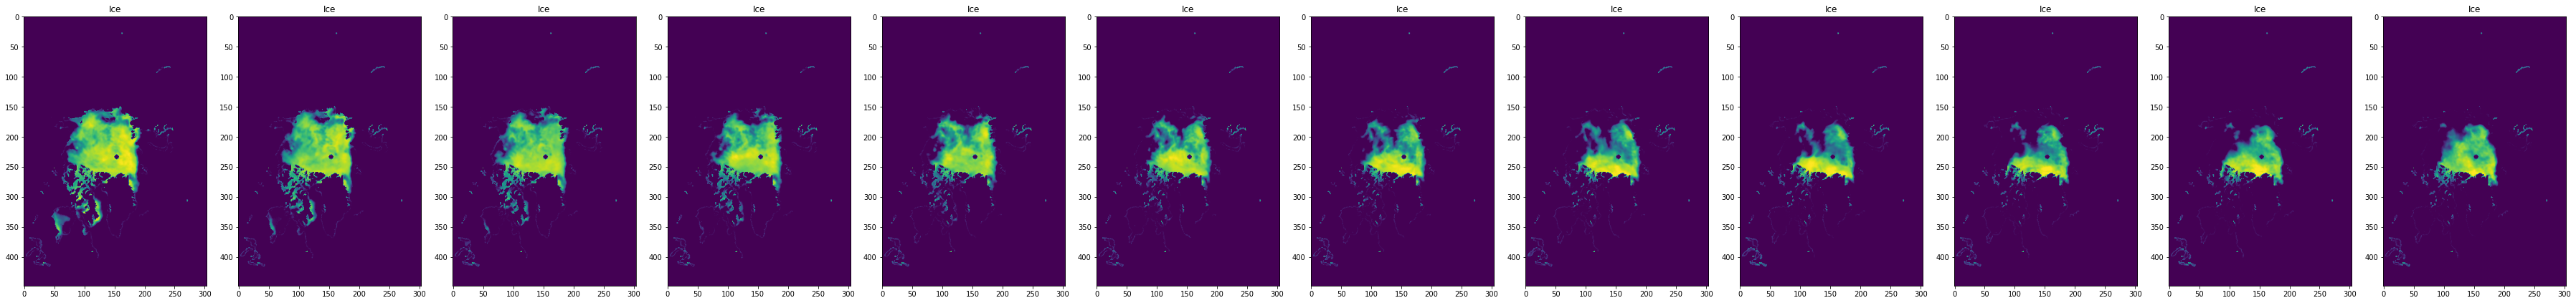

In [ ]:
show(test3)

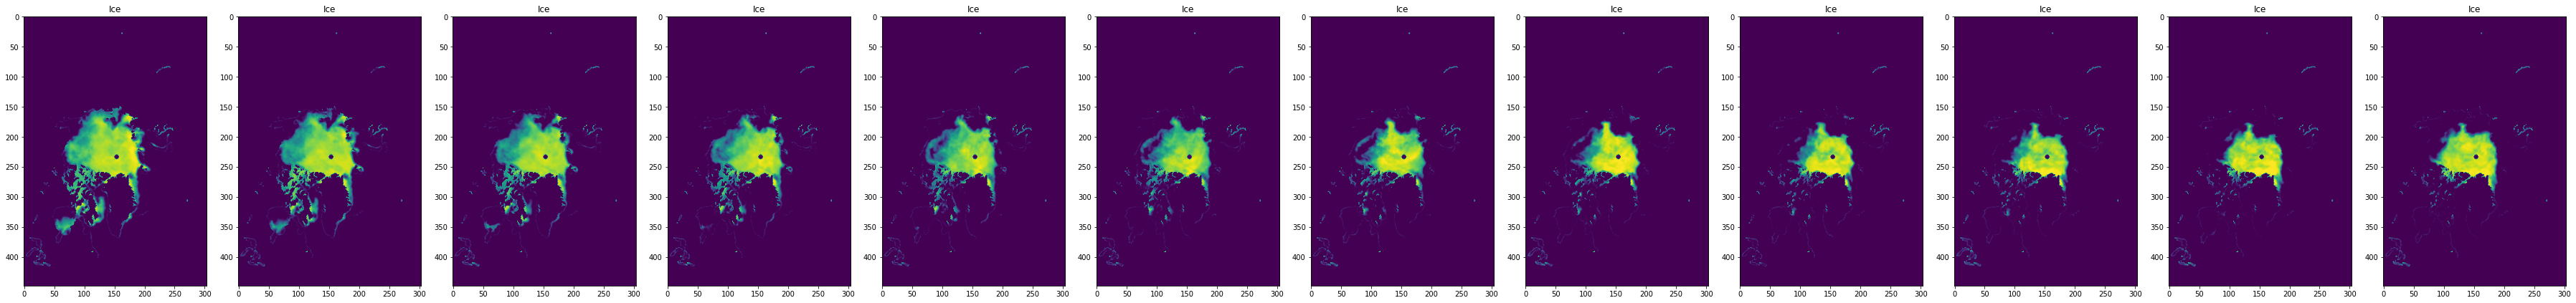

In [ ]:
show(test4)

In [ ]:
for i in [4,3,2,1,0]:
  print(i)

4
3
2
1
0


# 추론 데이터가 모델의 기초 
> 앙상블

> 이게 짱짱임

In [ ]:
# 이게 지금 짱짱
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(2)):
  te = globals()['test{}'.format(i)]

  # 데이터셋 나누기
  x_train = inference.reshape(24,-1).T
  y_train = te.reshape(12,-1).T
  x_test = inference.reshape(24,-1).T

  # 모델 훈련
  globals()['model{}'.format(i)] = KNeighborsRegressor(n_neighbors=1202, weights='distance', p=1, n_jobs=-1) #601
  globals()['model{}'.format(i)].fit(x_train, y_train)

  # 모델 예측
  predictions = globals()['model{}'.format(i)].predict(x_test)
  predictions = predictions.reshape(12,-1)

  # 변수 저장
  globals()['pred_{}'.format(i)] = predictions
  print(globals()['pred_{}'.format(i)].shape)

In [ ]:
pred_0 = pred_0.reshape(448*304, 12).T
pred_1 = pred_1.reshape(448*304, 12).T

In [ ]:
aaa = (pred_0 + pred_1)/2

In [ ]:
real = test0
a = aaa

print( "MAE : %s" % mae_score(real.reshape(12,-1), fun1(a)),
       '\n F1 : %s' % f1_score(real.reshape(12,-1), fun1(a)),
       '\n Final %s' % mae_over_f1(real.reshape(12,-1), fun1(a)))

MAE : 2.1710024144834743 
 F1 : 0.8710469463029681 
 Final 2.492405717939682


그대로 사용 가능

In [ ]:
# 1차 예측 데이터로 데이터셋을 생성
sh2017 = np.array(sh2017)
sh2018 = np.array(sh2018)
sh2019 = np.array(sh2019)

for i in tqdm(range(12)):
  globals()['pre{}'.format(i)] = np.array(np.concatenate((sh2017[i].reshape(1,448,304), sh2018[i].reshape(1,448,304), sh2019[i].reshape(1,448,304)), axis=0))
                                                           
  print(globals()['pre{}'.format(i)].shape)

In [ ]:
# 2차 추론 데이터 생성
ens = np.array(ens)

for i in tqdm(range(12)):
  globals()['pre2{}'.format(i)] = np.array(np.concatenate((sh2018[i].reshape(1,448,304), sh2019[i].reshape(1,448,304), ens[i].reshape(1,448,304)), axis=0))
                                                           
  print(globals()['pre2{}'.format(i)].shape)

In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  tr = globals()['pre{}'.format(i)]  # 앞서 예측된 2018년과 2019년
  te = globals()['test2019{}'.format(i)]  # 실제 2019년(daily2019)
  inf = globals()['pre2{}'.format(i)]  # 실제 2019년과 앙상블 2020년으로 예측을 실행

  # 데이터셋 나누기
  x_train = tr.reshape(3,-1).T
  y_train = te.reshape(1,-1).T
  x_test = inf.reshape(3,-1).T

  # 모델 훈련
  globals()['model{}'.format(i)] = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1)
  globals()['model{}'.format(i)].fit(x_train, y_train)

  # 모델 예측
  predictions = globals()['model{}'.format(i)].predict(x_test)
  predictions = predictions.reshape(1,-1)

  # 변수 저장
  globals()['pred__{}'.format(i)] = predictions
  print(globals()['pred__{}'.format(i)].shape)

  # 그래프 표시
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

In [ ]:
# 기본
# 제출 형태로 변환

# 데이터 생성
sh2 = pd.DataFrame(pred__0.reshape(1,-1))  # 초기값 설정
sh2 = fun1(sh2)  # 음수와 소숫점 없애기

for i in range(11):
  globals()['pred__{}'.format(i+1)] = globals()['pred__{}'.format(i+1)].reshape(1,-1)

  sh = globals()['pred__{}'.format(i+1)]
  sh = fun1(sh)  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  sh2 = pd.concat((sh2, sh), axis=0)
  print(sh2.shape)

In [ ]:
real = test0
a = np.array(sh2)

print( "MAE : %s" % mae_score(real.reshape(12,-1), fun1(a)),
       '\n F1 : %s' % f1_score(real.reshape(12,-1), fun1(a)),
       '\n Final %s' % mae_over_f1(real.reshape(12,-1), fun1(a)))

In [ ]:
real = test0
a = np.array(sh2)

print( "MAE : %s" % mae_score(real.reshape(12,-1), fun1(a)),
       '\n F1 : %s' % f1_score(real.reshape(12,-1), fun1(a)),
       '\n Final %s' % mae_over_f1(real.reshape(12,-1), fun1(a)))

MAE : 1.953487606956846 
 F1 : 0.8664641162767601 
 Final 2.254551051468317


# 추론 데이터가 모델의 기초2 이걸로
> 앙상블

In [ ]:
# 이게 지금 짱짱
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(3)):
  te = globals()['test1_{}'.format(i)]

  # 데이터셋 나누기
  x_train = inference.reshape(24,-1).T
  y_train = te.reshape(84,-1).T
  x_test = inference.reshape(24,-1).T

  # 모델 훈련
  globals()['model{}'.format(i)] = KNeighborsRegressor(n_neighbors=1202, weights='distance', p=1, n_jobs=-1) #601
  globals()['model{}'.format(i)].fit(x_train, y_train)

  # 모델 예측
  predictions = globals()['model{}'.format(i)].predict(x_test)
  predictions = predictions.reshape(84,-1)

  # 변수 저장
  globals()['pred_0_{}'.format(i)] = predictions
  print(globals()['pred_0_{}'.format(i)].shape)

  # 

 33%|███▎      | 1/3 [10:56<21:53, 656.92s/it]

(84, 136192)


 67%|██████▋   | 2/3 [21:52<10:56, 656.62s/it]

(84, 136192)


100%|██████████| 3/3 [32:54<00:00, 658.27s/it]

(84, 136192)


In [ ]:
pred_0 = pred_0_0.reshape(448*304, 84).T
pred_1 = pred_0_1.reshape(448*304, 84).T
pred_2 = pred_0_2.reshape(448*304, 84).T

In [ ]:
en = (pred_0 + pred_1)/2

In [ ]:
en1 = np.array([pred_0, pred_1]).mean(axis=0)

In [ ]:
sum(sum(en-en1))

0.0

In [ ]:
# 2019 예측을 12주로 만들기

for i in range(12):
  globals()['week2019{}'.format(i)] = np.array([pred_0[0 +(7*i)] , pred_0[1 +(7*i)] , pred_0[2 +(7*i)] , pred_0[3 +(7*i)] , pred_0[4 +(7*i)] , pred_0[5 +(7*i)] , pred_0[6 +(7*i)]]).mean(axis=0)
  print(globals()['week2019{}'.format(i)].shape)

In [ ]:
# 기본
# 제출 형태로 변환

# 데이터 생성
sh2019 = pd.DataFrame(week20190.reshape(1,-1))  # 초기값 설정
sh2019 = fun1(sh2019)  # 음수와 소숫점 없애기

for i in range(11):
  globals()['week2019{}'.format(i+1)] = globals()['week2019{}'.format(i+1)].reshape(1,-1)

  sh = globals()['week2019{}'.format(i+1)]
  sh = fun1(sh)  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  sh2019 = pd.concat((sh2019, sh), axis=0)
  print(sh2019.shape)

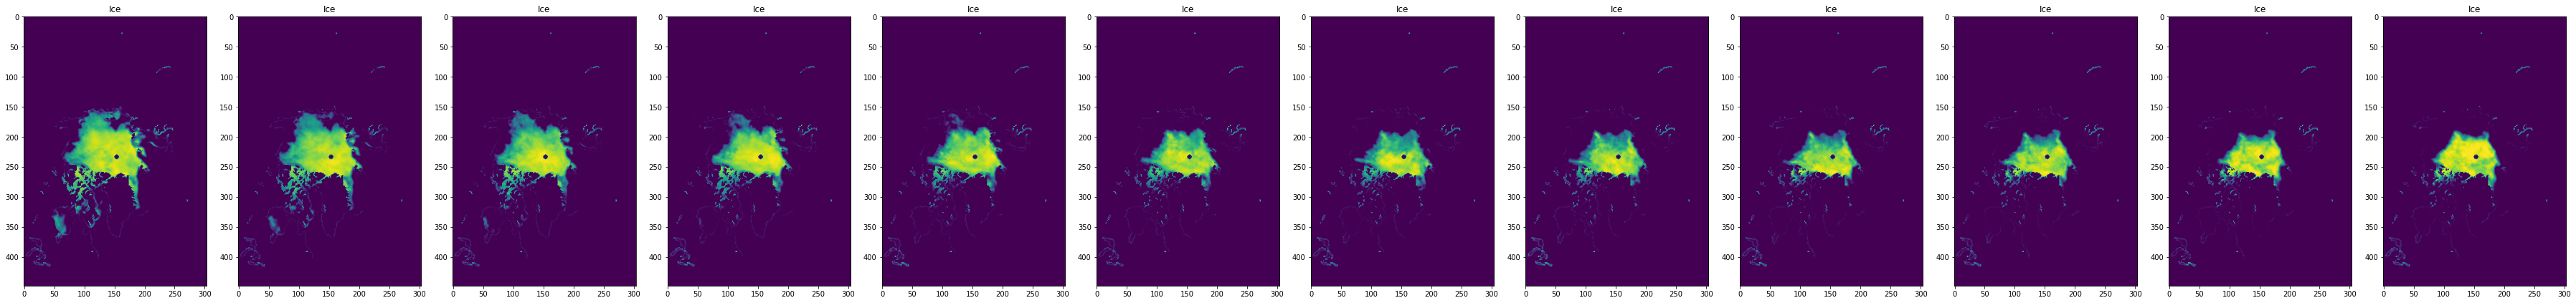

In [ ]:
show(np.array(sh2019).reshape(12,448,304))

In [ ]:
# 2018 예측을 12주로 만들기

for i in range(12):
  globals()['week2018{}'.format(i)] = np.array([pred_1[0 +(7*i)] , pred_1[1 +(7*i)] , pred_1[2 +(7*i)] , pred_1[3 +(7*i)] , pred_1[4 +(7*i)] , pred_1[5 +(7*i)] , pred_1[6 +(7*i)]]).mean(axis=0)
  print(globals()['week2018{}'.format(i)].shape)

In [ ]:
# 기본
# 제출 형태로 변환

# 데이터 생성
sh2018 = pd.DataFrame(week20180.reshape(1,-1))  # 초기값 설정
sh2018 = fun1(sh2018)  # 음수와 소숫점 없애기

for i in range(11):
  globals()['week2018{}'.format(i+1)] = globals()['week2018{}'.format(i+1)].reshape(1,-1)

  sh = globals()['week2018{}'.format(i+1)]
  sh = fun1(sh)  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  sh2018 = pd.concat((sh2018, sh), axis=0)
  print(sh2018.shape)

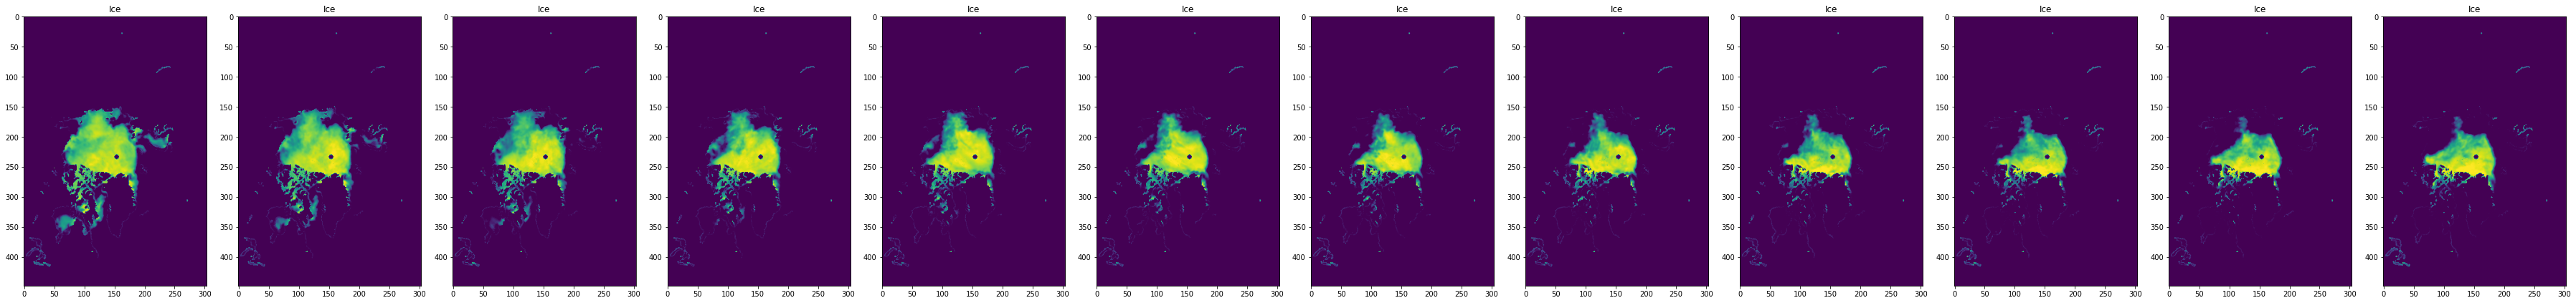

In [ ]:
show(np.array(sh2018).reshape(12,448,304))

In [ ]:
# 2017 예측을 12주로 만들기

for i in range(12):
  globals()['week2017{}'.format(i)] = np.array([pred_2[0 +(7*i)] , pred_2[1 +(7*i)] , pred_2[2 +(7*i)] , pred_2[3 +(7*i)] , pred_2[4 +(7*i)] , pred_2[5 +(7*i)] , pred_2[6 +(7*i)]]).mean(axis=0)
  print(globals()['week2017{}'.format(i)].shape)

In [ ]:
# 기본
# 제출 형태로 변환

# 데이터 생성
sh2017 = pd.DataFrame(week20170.reshape(1,-1))  # 초기값 설정
sh2017 = fun1(sh2017)  # 음수와 소숫점 없애기

for i in range(11):
  globals()['week2017{}'.format(i+1)] = globals()['week2017{}'.format(i+1)].reshape(1,-1)

  sh = globals()['week2017{}'.format(i+1)]
  sh = fun1(sh)  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  sh2017 = pd.concat((sh2017, sh), axis=0)
  print(sh2017.shape)

In [ ]:
show(np.array(sh2017).reshape(12,448,304))

In [ ]:
en = np.array(en)

In [ ]:
en.shape

(84, 136192)

In [ ]:
# 앙상블 예측을 12주로 만들기

for i in range(12):
  globals()['week{}'.format(i)] = np.array([en[0 +(7*i)] , en[1 +(7*i)] , en[2 +(7*i)] , en[3 +(7*i)] , en[4 +(7*i)] , en[5 +(7*i)] , en[6 +(7*i)]]).mean(axis=0)
  print(globals()['week{}'.format(i)].shape)

(136192,)
(136192,)
(136192,)
(136192,)
(136192,)
(136192,)
(136192,)
(136192,)
(136192,)
(136192,)
(136192,)
(136192,)


In [ ]:
# 기본
# 제출 형태로 변환

# 데이터 생성
ens = pd.DataFrame(week0.reshape(1,-1))  # 초기값 설정
ens = fun1(ens)  # 음수와 소숫점 없애기

for i in range(11):
  globals()['week{}'.format(i+1)] = globals()['week{}'.format(i+1)].reshape(1,-1)

  sh = globals()['week{}'.format(i+1)]
  sh = fun1(sh)  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  ens = pd.concat((ens, sh), axis=0)
  print(ens.shape)

(2, 136192)
(3, 136192)
(4, 136192)
(5, 136192)
(6, 136192)
(7, 136192)
(8, 136192)
(9, 136192)
(10, 136192)
(11, 136192)
(12, 136192)


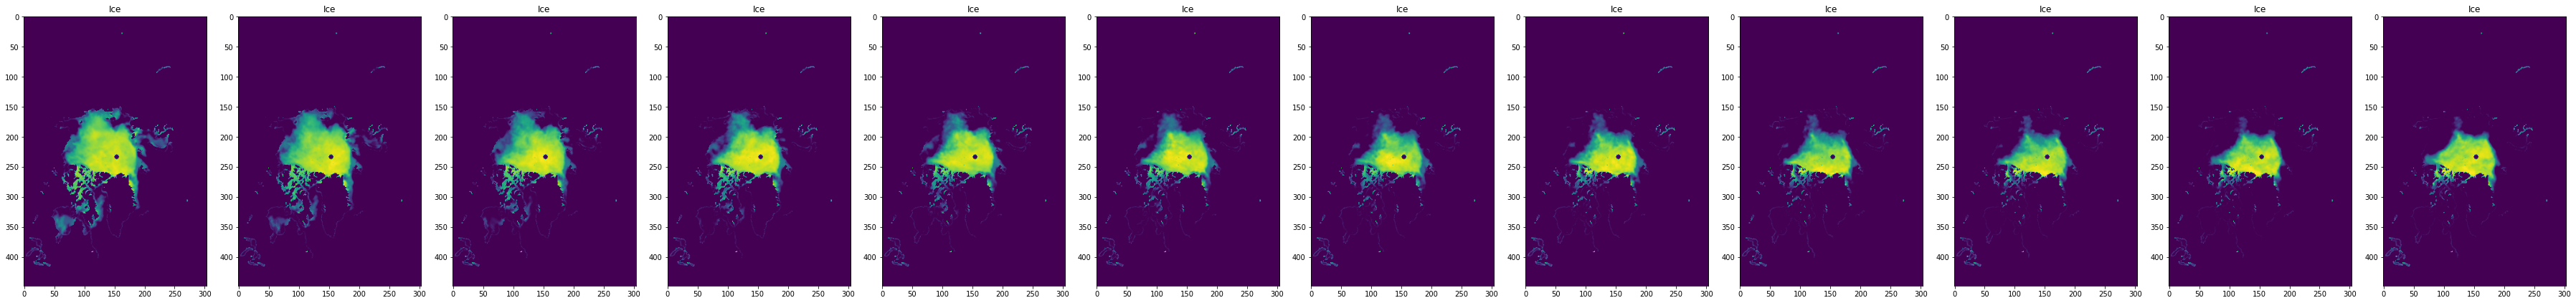

In [ ]:
show(np.array(ens).reshape(12,448,304))

In [ ]:
real = test0
a = aaa

print( "MAE : %s" % mae_score(real.reshape(12,-1), fun1(a)),
       '\n F1 : %s' % f1_score(real.reshape(12,-1), fun1(a)),
       '\n Final %s' % mae_over_f1(real.reshape(12,-1), fun1(a)))

MAE : 2.475458959899749 
 F1 : 0.8623186873798948 
 Final 2.8707007831574187


In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(4)):
  te = globals()['test{}'.format(i)]

  # 데이터셋 나누기
  x_train = inference.reshape(24,-1).T
  y_train = te.reshape(12,-1).T
  x_test = inference.reshape(24,-1).T

  # 모델 훈련
  globals()['model{}'.format(i)] = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1)
  globals()['model{}'.format(i)].fit(x_train, y_train)

  # 모델 예측
  predictions = globals()['model{}'.format(i)].predict(x_test)
  predictions = predictions.reshape(12,-1)

  # 변수 저장
  globals()['pred_{}'.format(i)] = predictions
  print(globals()['pred_{}'.format(i)].shape) 

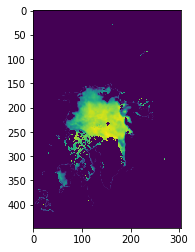

In [ ]:
plt.imshow(pred_0.reshape(448*304, 12)[:,0].reshape(448,304), interpolation = 'None')
plt.show()

앙상블 합치기

In [ ]:
pred_2.reshape(448*304, 12).T

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
aaaaaa = pred_2.reshape(448*304, 12).T

In [ ]:
aaaaaa[0].shape

(136192,)

In [ ]:
np.array(np.concatenate((pred_4.reshape(448*304, 12).T[0].reshape(1,136192), pred_3.reshape(448*304, 12).T[0].reshape(1,136192), pred_2.reshape(448*304, 12).T[0].reshape(1,136192), 
                         pred_1.reshape(448*304, 12).T[0].reshape(1,136192), pred_0.reshape(448*304, 12).T[0].reshape(1,136192)), axis=0)).shape

(5, 136192)

이게 2차 데이터를 의미

In [ ]:
bun = np.array(np.concatenate((pred_4.reshape(448*304, 12).T[0].reshape(1,136192), pred_3.reshape(448*304, 12).T[0].reshape(1,136192), pred_2.reshape(448*304, 12).T[0].reshape(1,136192), 
                         pred_1.reshape(448*304, 12).T[0].reshape(1,136192), pred_0.reshape(448*304, 12).T[0].reshape(1,136192)), axis=0))

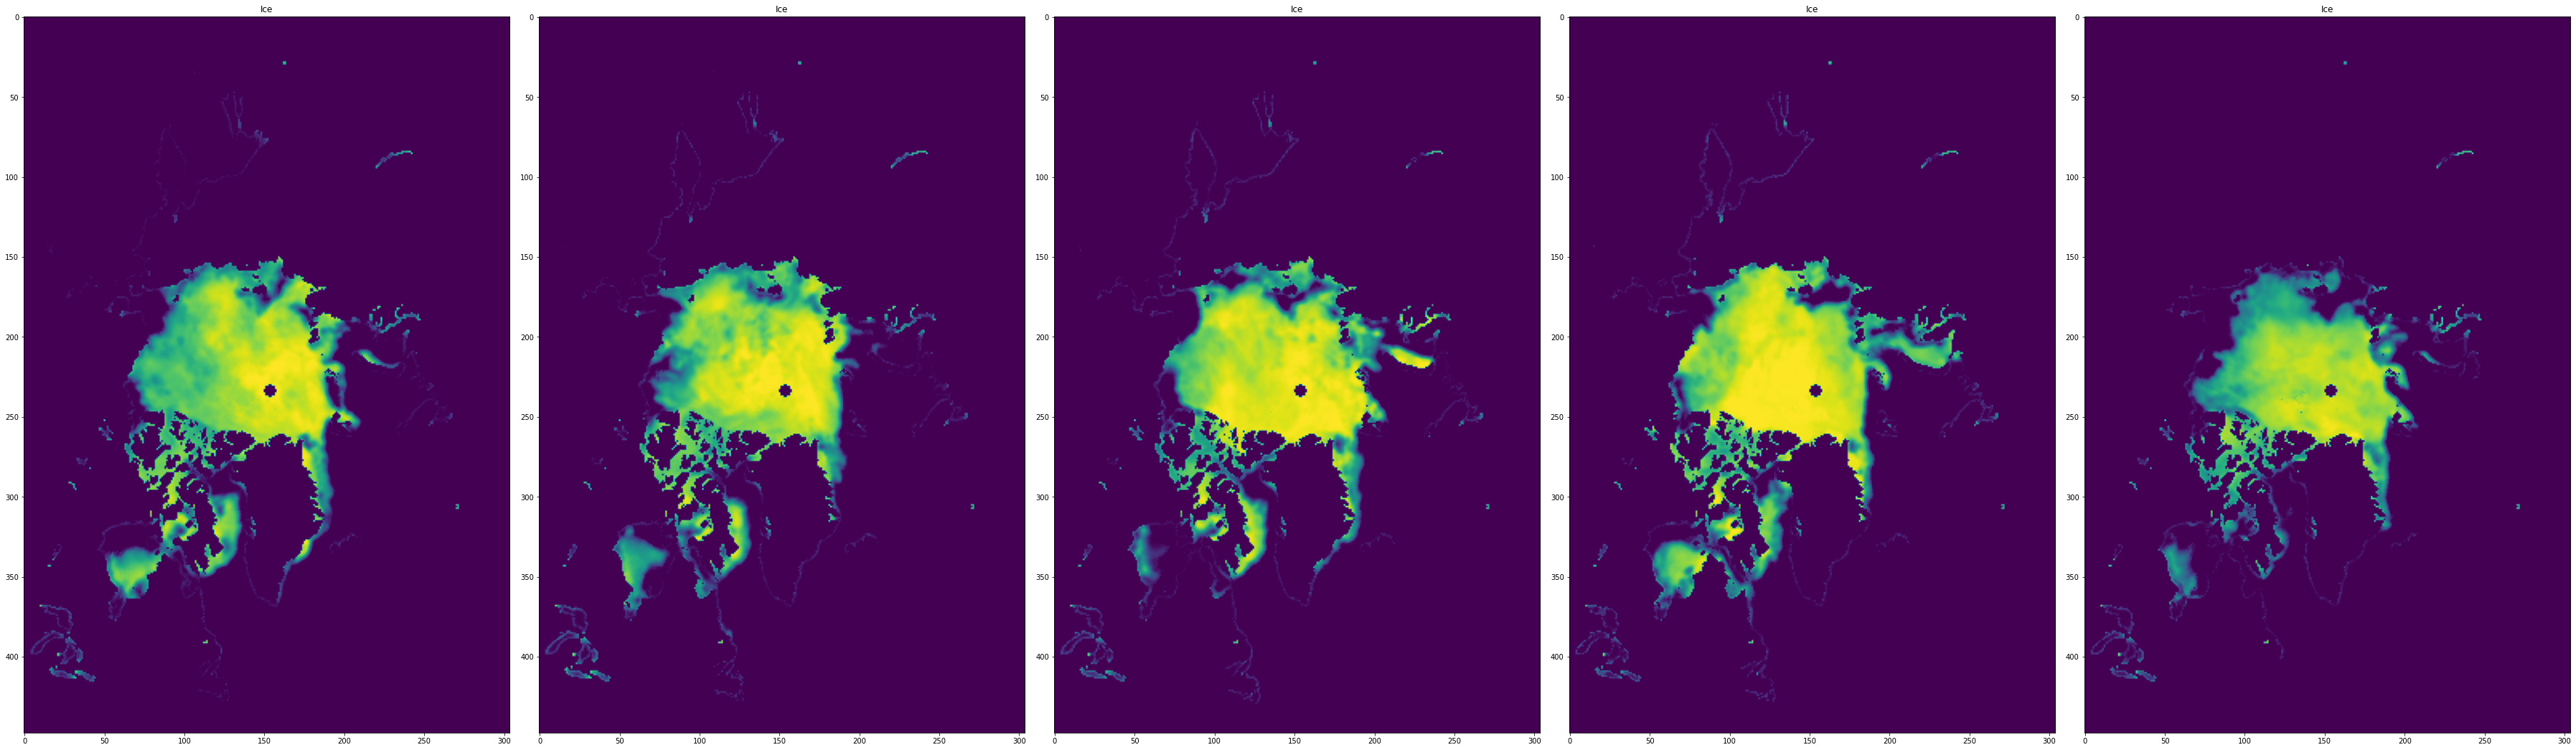

In [ ]:
show(bun.reshape(5,448,304))

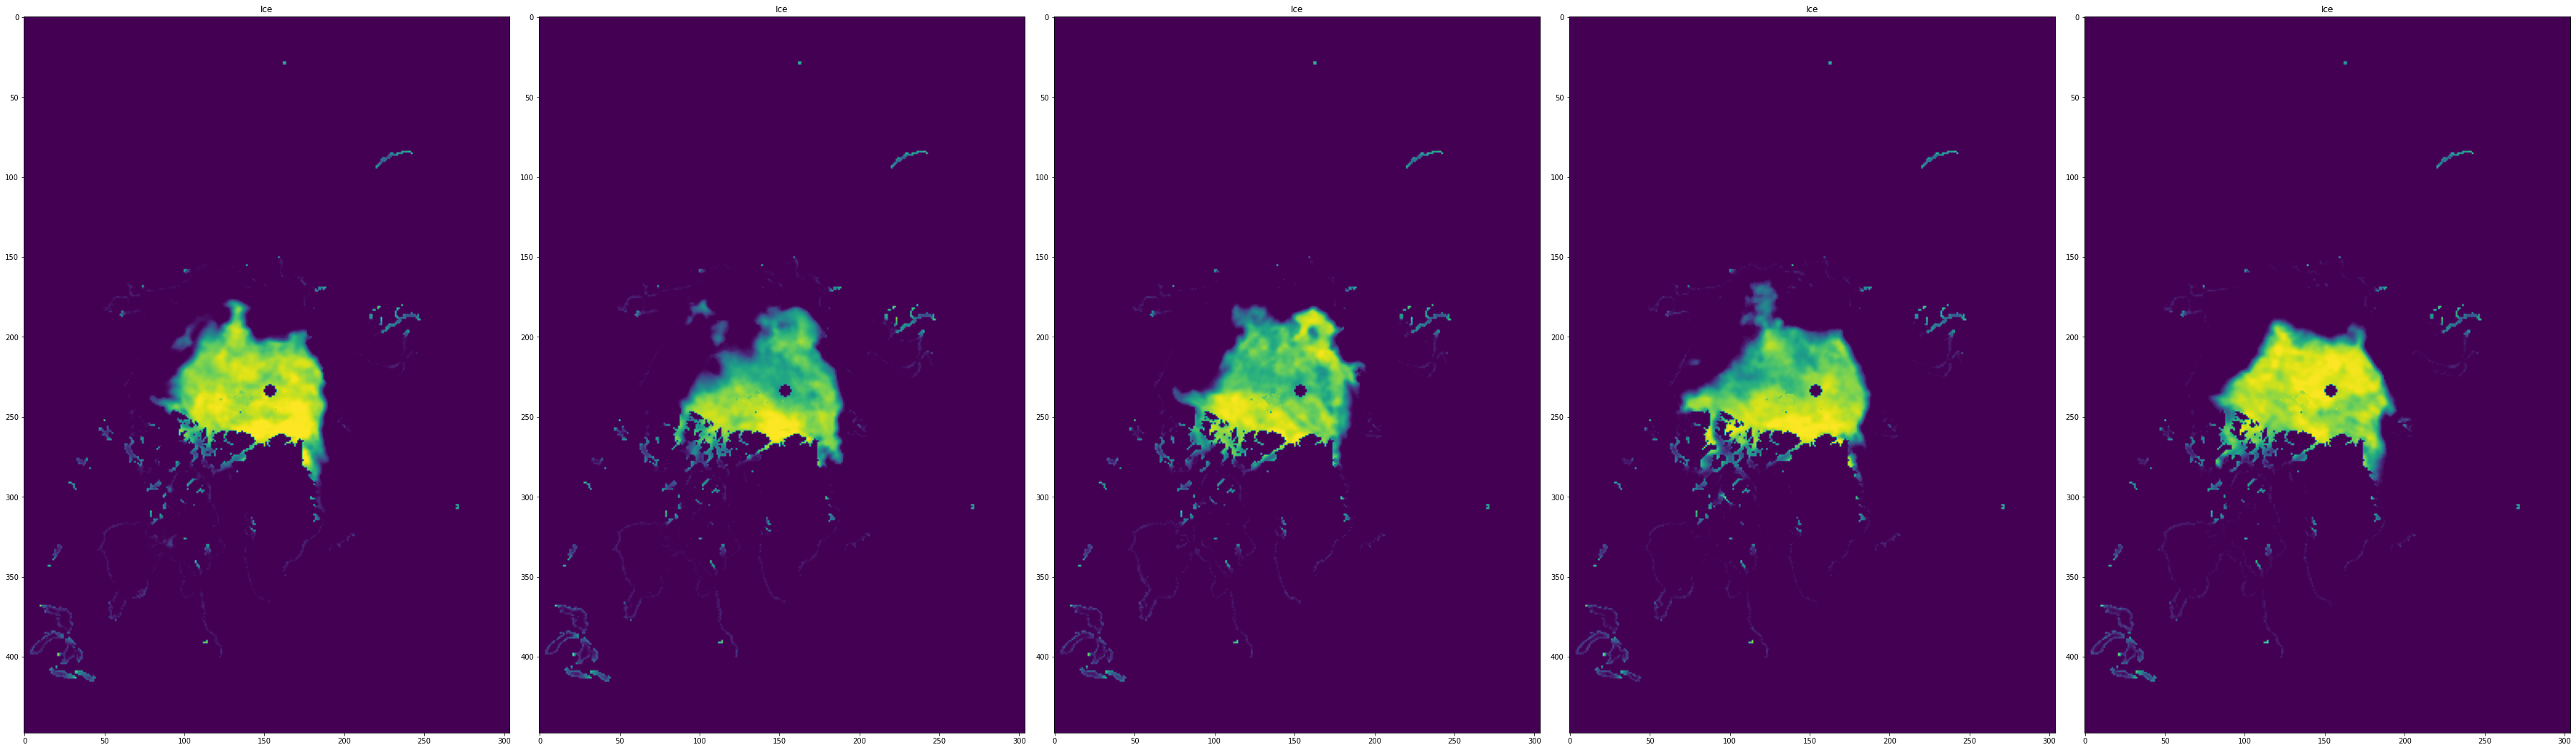

In [ ]:
show(predd2_11.reshape(5,448,304))

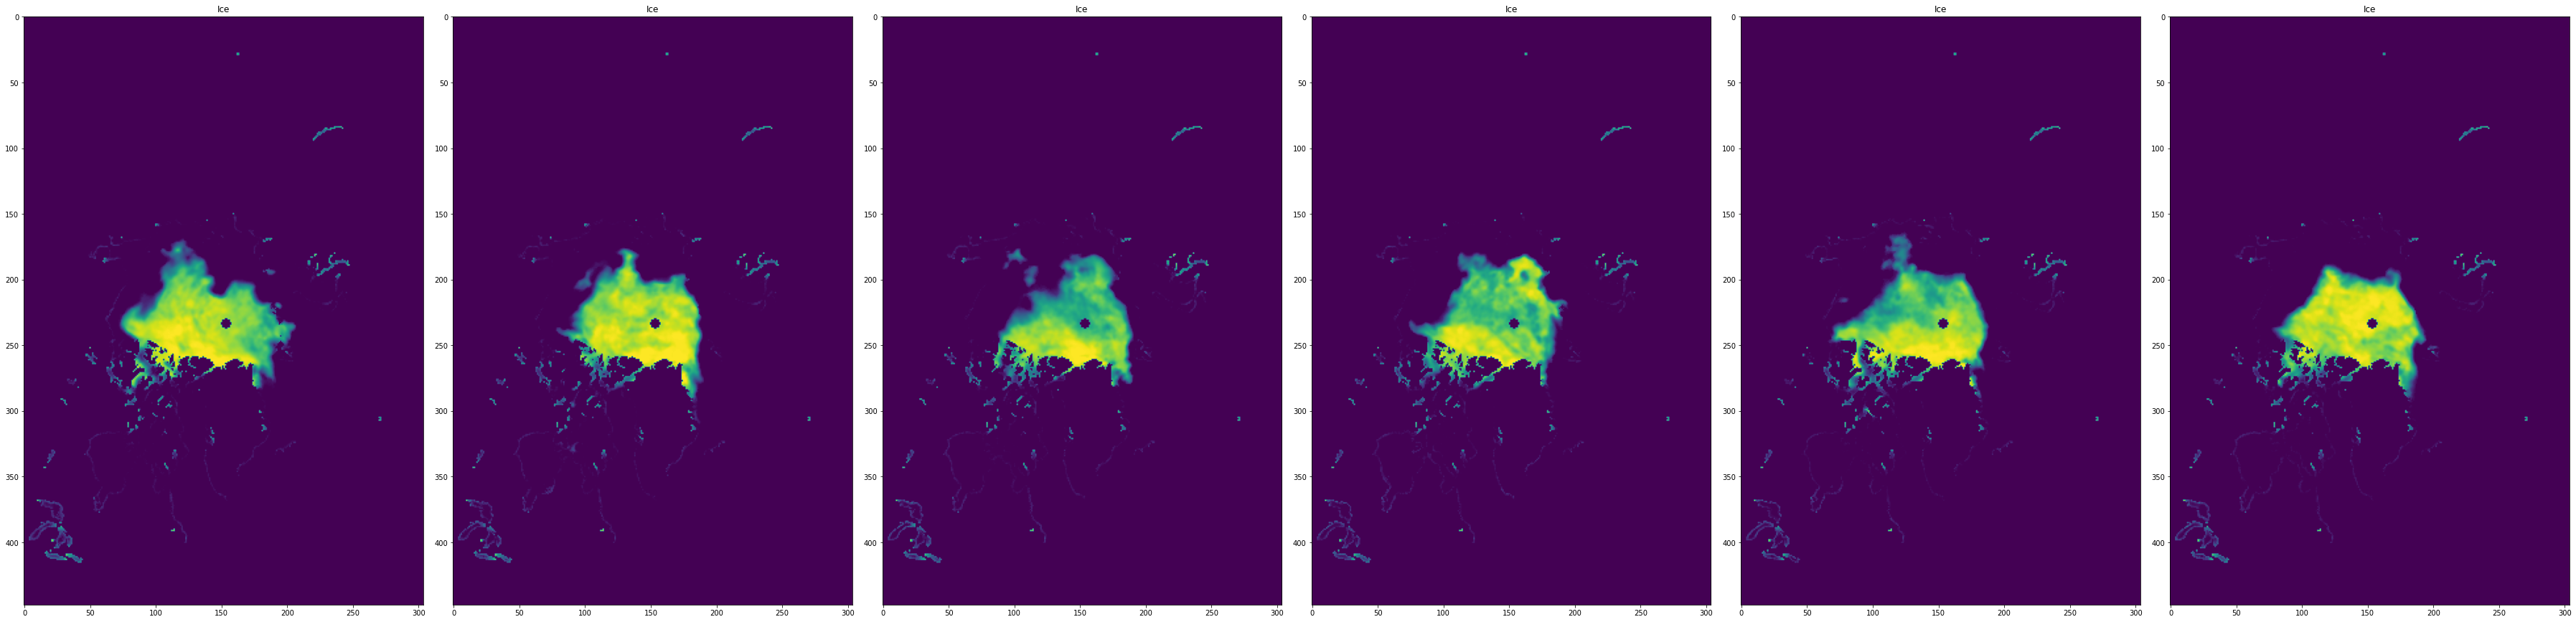

In [ ]:
show(testt2_11.reshape(6,448,304))

In [ ]:
# 2차 데이터 셋 만들기 (추론 데이터)
for i in range(12):
  preee = np.array(np.concatenate((# pred_4.reshape(448*304, 12).T[i].reshape(1,136192), 
                                  #  pred_3.reshape(448*304, 12).T[i].reshape(1,136192), pred_2.reshape(448*304, 12).T[i].reshape(1,136192), 
                                   pred_1.reshape(448*304, 12).T[i].reshape(1,136192), pred_0.reshape(448*304, 12).T[i].reshape(1,136192)), axis=0))
  
  globals()['predd2_{}'.format(i)] = preee
  print(globals()['predd2_{}'.format(i)].shape)


(2, 136192)
(2, 136192)
(2, 136192)
(2, 136192)
(2, 136192)
(2, 136192)
(2, 136192)
(2, 136192)
(2, 136192)
(2, 136192)
(2, 136192)
(2, 136192)


In [ ]:
# 2차 데이터 셋 만들기 (5:1의 예측 만들기)
# 2차 데이터 셋 만들기 (4:1의 예측 만들기)
for j in range(12):
  test222 = np.array(np.concatenate(( # test5[j].reshape(1,448,304), 
                                    #  test4[j].reshape(1,448,304), test3[j].reshape(1,448,304), 
                                     test2[j].reshape(1,448,304), test1[j].reshape(1,448,304), test0[j].reshape(1,448,304)), axis=0))
  
  globals()['testt2_{}'.format(j)] = test222
  print(globals()['testt2_{}'.format(j)].shape)

(3, 448, 304)
(3, 448, 304)
(3, 448, 304)
(3, 448, 304)
(3, 448, 304)
(3, 448, 304)
(3, 448, 304)
(3, 448, 304)
(3, 448, 304)
(3, 448, 304)
(3, 448, 304)
(3, 448, 304)


In [ ]:
test0.shape

(12, 448, 304)

In [ ]:
testt2_0[:5].shape

(5, 448, 304)

In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['testt2_{}'.format(i)]
  xx_test = globals()['predd2_{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[:2].reshape(2,-1).T
  y_train = datan[2].reshape(1,-1).T
  x_test = xx_test.reshape(2,-1).T

  # 모델 훈련
  model = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1) #601
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)
  predictions = predictions.reshape(-1)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pre{}'.format(i)] = predictions
  print(globals()['pre{}'.format(i)].shape)

  0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# 기본
# 제출 형태로 변환

# 데이터 생성
sh2 = pd.DataFrame(pre0.reshape(1,-1))  # 초기값 설정
sh2 = fun1(sh2)  # 음수와 소숫점 없애기

for i in range(11):
  globals()['pre{}'.format(i+1)] = globals()['pre{}'.format(i+1)].reshape(1,-1)

  sh = globals()['pre{}'.format(i+1)]
  sh = fun1(sh)  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  sh2 = pd.concat((sh2, sh), axis=0)
  print(sh2.shape)

(2, 136192)
(3, 136192)
(4, 136192)
(5, 136192)
(6, 136192)
(7, 136192)
(8, 136192)
(9, 136192)
(10, 136192)
(11, 136192)
(12, 136192)


In [ ]:
aa = (pred_0 + pred_1)/2
aa.shape

(12, 136192)

In [ ]:
aa = (pred_0 + pred_1 + pred_2 + pred_3 + pred_4 + pred_5)/6
aa.shape

(12, 136192)

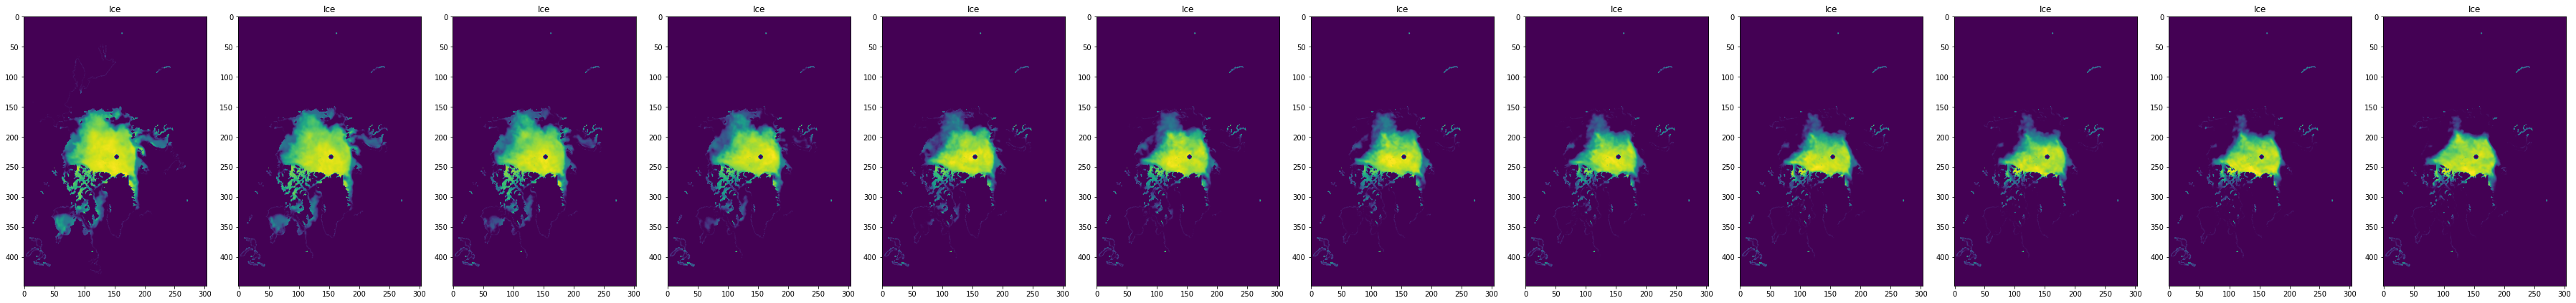

In [ ]:
show(aa.reshape(448*304, 12).T.reshape(12,448,304))

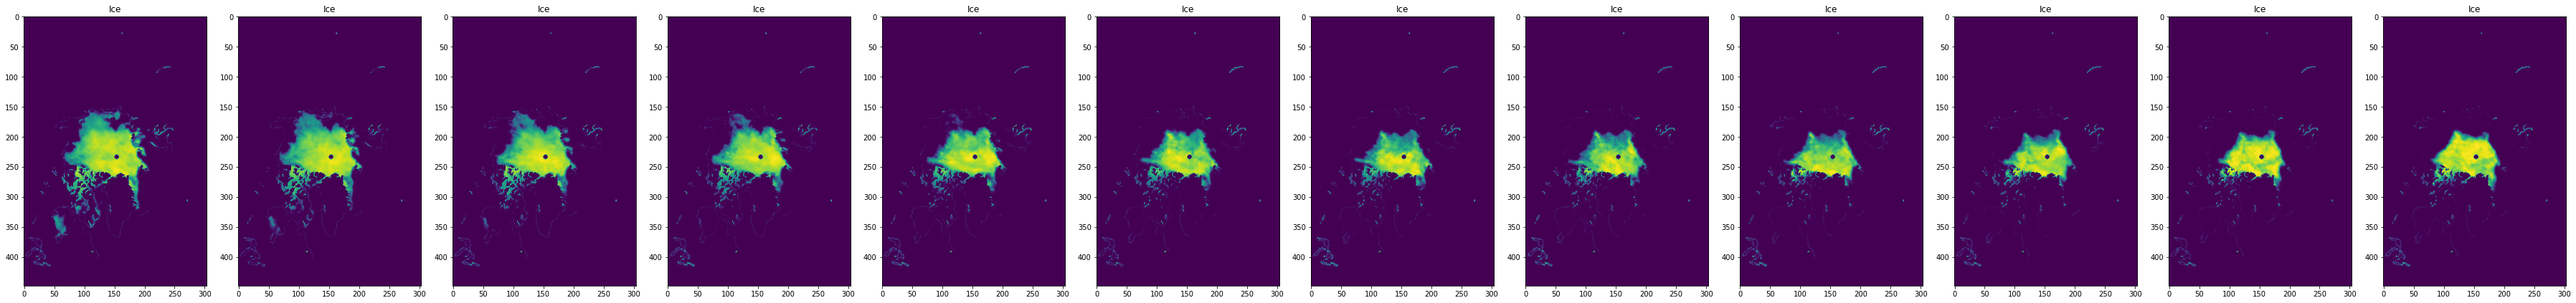

In [ ]:
show(test0)

In [ ]:
aa.shape

(12, 136192)

In [ ]:
aa.reshape(448*304, 12).T.shape

(12, 136192)

In [ ]:
aaa1 = aa.reshape(448*304, 12).T

# 제출

In [ ]:
aaa1 = pd.DataFrame(ens)

In [ ]:
aaa1 = fun1(aaa1)

In [ ]:
# 제출 데이터 인덱스 수정

# 2019 데이터와 2020 예측 합치기
result = pd.concat([aaa1,aaa1], axis=0)
result = result.reset_index(drop=True)

# 제출 파일과 결합
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/북극해빙/data1/sample_submission.csv")
sub = pd.concat([submission.loc[:,'week_start'],result], axis=1)
sub.columns = submission.columns.values  # 제출파일에서 컬럼명을 
sub.tail()

week_start    0    1    2    3  ...  136187  136188  136189  136190  136191
19  2021-08-23  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
20  2021-08-30  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
21  2021-09-06  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
22  2021-09-13  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
23  2021-09-20  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0

[5 rows x 136193 columns]

In [ ]:
sh2

0       1       2       3       ...  136188  136189  136190  136191
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0

[12 rows x 136192 columns]

In [ ]:
# 제출 데이터 인덱스 수정

# 2019 데이터와 2020 예측 합치기
result = pd.concat([sh2,sh2], axis=0)
result = result.reset_index(drop=True)

# 제출 파일과 결합
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/북극해빙/data/sample_submission.csv")
sub = pd.concat([submission.loc[:,'week_start'],result], axis=1)
sub.columns = submission.columns.values  # 제출파일에서 컬럼명을 
sub.tail()

week_start    0    1    2    3  ...  136187  136188  136189  136190  136191
19  2021-08-23  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
20  2021-08-30  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
21  2021-09-06  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
22  2021-09-13  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
23  2021-09-20  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0

[5 rows x 136193 columns]

Text(0.5, 1.0, 'Lets Final Check')

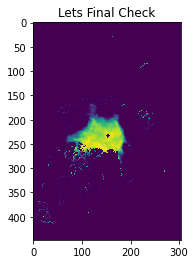

In [ ]:
# 2차 데이터 확인 (최종 제출본)
check = np.array(sub.iloc[10,1:], dtype=np.float64).reshape(448,304)

import matplotlib.pyplot
matplotlib.pyplot.imshow(check, interpolation = 'None')
matplotlib.pyplot.title('Lets Final Check')

In [ ]:
# 제출파일 완성 및 제출
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/result/sub_0625_2_KNN(2en_1202_daily_12week3year).csv', index = False)

수고하셨습니다. ( ⁎ ᵕᴗᵕ ⁎ )

 --------------------

---------------------------

> 부록) 2019 예측
* ᕕ( ՞ ᗜ ՞ )ᕗ 혹시 2019년 예측을 보고 싶은 분들을 위한 2019 예측 코드입니다.
* 모델 부분에 넣으셔서 실행하시면 됩니다.
* 리더보드 'public' 점수 3.857051597이 나오실 것입니다.

In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[6:18].reshape(12,-1).T 
  y_train = datan[18].reshape(1,-1).T
  x_test = datan[7:19].reshape(12,-1).T

  # 모델 훈련
  model = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1) 
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)
  predictions = predictions.reshape(-1)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

-------------

* 코드 공유는 여기까지 입니다.
* 대회 초부터 많은 코드를 작성하였지만 가장 결과가 좋은 모델이자 코드들입니다. 
* (나머지 코드들은 제 깃허브에 가시면 난잡하게 업로드 되어 있을 것입니다 (；☉_☉)

> 정말 수고하셨습니다. ( ´╹ᗜ╹`*)
* 궁금한 사항 있으시면 댓글을 통해 답변드리겠습니다.